In [1]:
from __future__ import print_function
from __future__ import division
import shutil
import gdown
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np 
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt 
import time
import os 
import copy
import random

from pathlib import Path

/home/jason/anaconda3/envs/tadac/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print(f"Torch version: {torch.__version__}")
print(f"Torchvision version: {torchvision.__version__}")

Torch version: 1.12.1
Torchvision version: 0.13.1


In [3]:
# data directory 
data_dir = Path('../../data')
if not data_dir.is_dir():
    data_dir.mkdir(parents=True, exist_ok=True)

# model names
model_names = ['resnet', 'alexnet', 'vgg', 'squeezenet', 'densenet', 'inception']
model_names = [ 'squeezenet']

# select a model name randomly
model_name = random.choice(model_names)

print(f"Model name: {model_name}")

Model name: squeezenet


In [4]:
# download data
DATASET_URL = "https://drive.google.com/uc?id=1h9Zvm0UKeGMk8hXSdfCJ5E1hIgxvQHN6"
DATASET_FOLDER_NAME = "food10"
DATASET_ZIP_FILENAME = "food10.zip"
DATASET_ZIP_FILEPATH = data_dir.joinpath(DATASET_ZIP_FILENAME)
DATASET_FOLDER_PATH = data_dir.joinpath(DATASET_FOLDER_NAME)

# check if there isn't exist
if not DATASET_ZIP_FILEPATH.is_file():
    print(f"The file {DATASET_ZIP_FILENAME} is downloading...")

    try:
        gdown.download(url=DATASET_URL, output=str(DATASET_ZIP_FILEPATH))
        print(f"The {DATASET_ZIP_FILENAME} is downloaded successfully.")
    except Exception as error:
        print(f"Caught this error {error}")

else:
    print(f"The {DATASET_ZIP_FILENAME} already exists.")


# check if there isn't exist
if not DATASET_FOLDER_PATH.is_dir():
    try:

        print(f"The {DATASET_ZIP_FILENAME} is extracting...")
        gdown.extractall(path=str(DATASET_ZIP_FILEPATH), to=str(data_dir))
        print(f"The {DATASET_ZIP_FILENAME} is extracted successfully.")

    except Exception as error:
        print(f"Caught this error {error}")

else:
    print(f"The folder {DATASET_FOLDER_PATH} is already extracted. Skipped extracting.")


The food10.zip already exists.
The folder ../../data/food10 is already extracted. Skipped extracting.


In [5]:
def create_validation_data(dataset_dir: Path, val_dir: str, ratio: int = 0.2):
    if not dataset_dir.is_dir():
        print(f"The directory is not found. Please check it before continuing.")
        exit()
    else:
        print(f"Start splitting the dataset directory into `train_dir` and `val_dir`.")
        
        # all class names
        dir_names = os.listdir(dataset_dir)
        
        # split to train, val
        for dir_name in dir_names:

            class_dir = dataset_dir.joinpath(dir_name)
            val_class_dir = val_dir.joinpath(dir_name)

            if not val_class_dir.is_dir():
                val_class_dir.mkdir(parents=True, exist_ok=True)

            class_file_paths =[entry.path for entry in list(os.scandir(class_dir))]
            sub_file_paths = random.sample(class_file_paths, int(ratio * len(class_file_paths)))
            
            for sub_file_path in sub_file_paths:
                shutil.copy(sub_file_path, val_class_dir)

# train dir
dataset_dir = DATASET_FOLDER_PATH.joinpath("train")
train_dir = DATASET_FOLDER_PATH.joinpath("train")
test_dir = DATASET_FOLDER_PATH.joinpath("test")

# val dir
val_dir = DATASET_FOLDER_PATH.joinpath("val")
if not val_dir.is_dir():
    print(f"Validation data is creating...")
    val_dir.mkdir(parents=True, exist_ok=True)

    # create a validation data
    create_validation_data(dataset_dir=dataset_dir, val_dir=val_dir)
else:
    print(f"Validation data already exists.")

Validation data already exists.


In [6]:
# list of class names
class_names = sorted(list(os.listdir(train_dir)))
class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [7]:
# number of classes
num_classes = len(class_names)

# batch size
batch_size = 16

# number of epochs
num_epochs = 15

# feature extractor
feature_extract = True

# fine tuning
fine_tuning = False

# from scratch 
from_scratch = False

# device 
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

Device: cuda


In [8]:
def set_parameter_requires_grad(model, feature_extracting=True, fine_tuning=False, from_scratch=False):

    # feature extractor
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
            
    # fine-tuning
    if fine_tuning:
        i = 0
        for param in model.parameters():
            if i < 10:
                param.requires_grad = False
            i += 1


In [9]:
def initalize_model(model_name, num_classes, feature_extract, fine_tuning, from_scratch, use_pretrained=True):
    model = None
    input_size = 0

    if model_name == "resnet":
        """Resnet18
        """
        model = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model=model, feature_extracting=feature_extract, fine_tuning=fine_tuning, from_scratch=from_scratch)
        num_in_features = model.fc.in_features
        model.fc = nn.Linear(num_in_features, num_classes)
        input_size = 224
    elif model_name == "alexnet":
        """AlexNet
        """
        model = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model=model, feature_extracting=feature_extract, fine_tuning=fine_tuning, from_scratch=from_scratch)
        num_in_features = model.classifier[6].in_features
        model.classifier[6] = nn.Linear(num_in_features, num_classes)
        input_size = 224
    elif model_name == "vgg":
        """VGG11_bn
        """
        model = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model=model, feature_extracting=feature_extract, fine_tuning=fine_tuning, from_scratch=from_scratch)
        num_in_features = model.classifier[6].in_features
        model.classifier[6] = nn.Linear(num_in_features, num_classes)
        input_size = 224
    elif model_name == "squeezenet":
        """Squeezenet
        """
        model = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model=model, feature_extracting=feature_extract, fine_tuning=fine_tuning, from_scratch=from_scratch)
        model.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model.num_classes = num_classes
        input_size = 224
    elif model_name == "densenet":
        """DenseNet
        """
        model = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model=model, feature_extracting=feature_extract, fine_tuning=fine_tuning, from_scratch=from_scratch)
        num_in_features = model.classifier.in_features
        model.classifier = nn.Linear(num_in_features, num_classes)
        input_size = 224
    elif model_name == "inception":
        """Inception v3
        Be careful, expects (229, 229) sized images and has auxiliary output
        """
        model = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model=model, feature_extracting=feature_extract, fine_tuning=fine_tuning, from_scratch=from_scratch)

        # handle the auxilary net
        num_in_features = model.AuxLogits.fc.in_features
        model.AuxLogits.fc = nn.Linear(num_in_features, num_classes)

        # handle the primary net
        num_in_features = model.fc.in_features
        model.fc = nn.Linear(num_in_features, num_classes)
        input_size = 229
    else:
        print("Invalid model name, exiting...")
        exit()

    return model, input_size

In [10]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    start_timer = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())

    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f"Epoch {epoch +  1} / {num_epochs}")
        print('-'*40)

        # each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train() # training mode
            else:
                model.eval() # evaluate mode
        
            running_loss = 0.0
            running_corrects = 0

            # iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train 
                with torch.set_grad_enabled(phase == 'train'):
                    # from rom https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                    if is_inception and phase == 'train': 
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4 * loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                    
                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                
                # statistics 
                # print(f"inputs.size(0): {inputs.size(0)}")
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects / len(dataloaders[phase].dataset)

            print(f"Phase: {phase} | Loss: {epoch_loss: .4f} | Acc: {epoch_acc: .4f}")

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()
    
    time_elapsed = time.time() - start_timer
    print(f"Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
    print(f"Best val acc: {best_acc:.4f}")

    
    # load the best model weights
    model.load_state_dict(best_model_wts)
    
    return model, val_acc_history

#### Transfer Learning - `Feature Extraction` 

In [11]:
# initialize the model for this
model_0, input_size_0 = initalize_model(model_name=model_name, num_classes=num_classes, feature_extract=True, fine_tuning=False, from_scratch=False, use_pretrained=True)

# print out the model
# print(model_0)

# data augmentation and normalization
data_transform = {
    "train": transforms.Compose([
        transforms.RandomResizedCrop(input_size_0),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    "val": transforms.Compose([
        transforms.RandomResizedCrop(input_size_0),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
}

print("Initializing Datasets and Dataloaders....")

# create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(DATASET_FOLDER_PATH, x), data_transform[x]) for x in ["train", "val"]}

# create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ["train", "val"]}

print(f"Dataloader Dict: {dataloaders_dict}")

# send the model to device
model_0 = model_0.to(device)

# fine-tuning: will be updating all parameters
# feature extractor: only update the parameters that have initialized (the parameters with require_grad is True)

# params to update
params_to_update = model_0.parameters()
print("[Feature Extraction - Transfer Learning] - Params to learn:")

if feature_extract:
    params_to_update = []
    for name, param in model_0.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t", name)
            
if fine_tuning or from_scratch: 
    for name, param in model_0.named_parameters():
        if param.requires_grad == True: 
            print("\t", name)

# optimizer
optimizer = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

# loss function
loss_fn = nn.CrossEntropyLoss()

# is_inception
is_inception = True if model_name=="inception" else False

# train and evaluate
model_0, hist_0 = train_model(model=model_0, dataloaders=dataloaders_dict, criterion=loss_fn, optimizer=optimizer, num_epochs= num_epochs, is_inception=is_inception)

Initializing Datasets and Dataloaders....
Dataloader Dict: {'train': <torch.utils.data.dataloader.DataLoader object at 0x7f17e655e670>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f17e655e6a0>}


/home/jason/anaconda3/envs/tadac/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/jason/anaconda3/envs/tadac/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=SqueezeNet1_0_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[Feature Extraction - Transfer Learning] - Params to learn:
	 classifier.1.weight
	 classifier.1.bias
Epoch 1 / 15
----------------------------------------
Phase: train | Loss:  1.3031 | Acc:  0.5768
Phase: val | Loss:  1.0284 | Acc:  0.6813

Epoch 2 / 15
----------------------------------------
Phase: train | Loss:  1.0289 | Acc:  0.6704
Phase: val | Loss:  0.9526 | Acc:  0.7047

Epoch 3 / 15
----------------------------------------
Phase: train | Loss:  0.9626 | Acc:  0.6915
Phase: val | Loss:  0.9052 | Acc:  0.7140

Epoch 4 / 15
----------------------------------------
Phase: train | Loss:  0.9010 | Acc:  0.7089
Phase: val | Loss:  0.8990 | Acc:  0.7180

Epoch 5 / 15
----------------------------------------
Phase: train | Loss:  0.8892 | Acc:  0.7087
Phase: val | Loss:  0.8912 | Acc:  0.7207

Epoch 6 / 15
----------------------------------------
Phase: train | Loss:  0.8703 | Acc:  0.7232
Phase: val | Loss:  0.7867 | Acc:  0.7547

Epoch 7 / 15
---------------------------------------

#### Transfer Learning - `Fine-tuning` 

In [12]:
# initialize the model for this
model_1, input_size_1 = initalize_model(model_name=model_name, num_classes=num_classes, feature_extract=False, fine_tuning=True, from_scratch= False, use_pretrained=True)

# print out the model
# print(model_1)

# data augmentation and normalization
data_transform = {
    "train": transforms.Compose([
        transforms.RandomResizedCrop(input_size_1),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    "val": transforms.Compose([
        transforms.RandomResizedCrop(input_size_1),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
}

print("Initializing Datasets and Dataloaders....")

# create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(DATASET_FOLDER_PATH, x), data_transform[x]) for x in ["train", "val"]}

# create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ["train", "val"]}

print(f"Dataloader Dict: {dataloaders_dict}")

# send the model to device
model_1 = model_1.to(device)

# fine-tuning: will be updating all parameters
# feature extractor: only update the parameters that have initialized (the parameters with require_grad is True)

# params to update
params_to_update = model_1.parameters()
print("[Fine-tuning - Transfer Learning] - Params to learn:")

if feature_extract:
    params_to_update = []
    for name, param in model_1.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t", name)
            
if fine_tuning or from_scratch: 
    for name, param in model_1.named_parameters():
        if param.requires_grad == True: 
            print("\t", name)

# optimizer
optimizer = optim.SGD(params_to_update, lr=0.0001 , momentum=0.9) # learning rate: 10x lower 

# loss function
loss_fn = nn.CrossEntropyLoss()

# is_inception
is_inception = True if model_name=="inception" else False

# train and evaluate
model_1, hist_1 = train_model(model=model_1, dataloaders=dataloaders_dict, criterion=loss_fn, optimizer=optimizer, num_epochs= num_epochs, is_inception=is_inception)

Initializing Datasets and Dataloaders....
Dataloader Dict: {'train': <torch.utils.data.dataloader.DataLoader object at 0x7f179e161070>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f179e161580>}
[Fine-tuning - Transfer Learning] - Params to learn:
	 features.4.expand1x1.weight
	 features.4.expand1x1.bias
	 features.4.expand3x3.weight
	 features.4.expand3x3.bias
	 features.5.squeeze.weight
	 features.5.squeeze.bias
	 features.5.expand1x1.weight
	 features.5.expand1x1.bias
	 features.5.expand3x3.weight
	 features.5.expand3x3.bias
	 features.7.squeeze.weight
	 features.7.squeeze.bias
	 features.7.expand1x1.weight
	 features.7.expand1x1.bias
	 features.7.expand3x3.weight
	 features.7.expand3x3.bias
	 features.8.squeeze.weight
	 features.8.squeeze.bias
	 features.8.expand1x1.weight
	 features.8.expand1x1.bias
	 features.8.expand3x3.weight
	 features.8.expand3x3.bias
	 features.9.squeeze.weight
	 features.9.squeeze.bias
	 features.9.expand1x1.weight
	 features.9.expand1x1.bias

#### Transfer Learning - `From Scratch` 

In [13]:
# initialize the non-pretrained version of the model 
model_2, input_size_2 = initalize_model(model_name=model_name, num_classes=num_classes, feature_extract=False, fine_tuning=False, from_scratch= True, use_pretrained=False)


# print out the model
# print(model_2)

# data augmentation and normalization
data_transform = {
    "train": transforms.Compose([
        transforms.RandomResizedCrop(input_size_2),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    "val": transforms.Compose([
        transforms.RandomResizedCrop(input_size_2),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
}

print("Initializing Datasets and Dataloaders....")

# create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(DATASET_FOLDER_PATH, x), data_transform[x]) for x in ["train", "val"]}

# create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ["train", "val"]}

print(f"Dataloader Dict: {dataloaders_dict}")

# send to device
model_2 = model_2.to(device)

# fine-tuning: will be updating all parameters
# feature extractor: only update the parameters that have initialized (the parameters with require_grad is True)

# params to update
params_to_update = model_2.parameters()
print("[From scratch] - Params to learn:")

if feature_extract:
    params_to_update = []
    for name, param in model_2.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t", name)
            
if fine_tuning or from_scratch: 
    for name, param in model_2.named_parameters():
        if param.requires_grad == True: 
            print("\t", name)


# optimizer
optimizer = optim.SGD(model_2.parameters(), lr=0.001, momentum=0.9)

# loss function
loss_fn = nn.CrossEntropyLoss()

# is_inception
is_inception = True if model_name=="inception" else False

# train and evaluate
model_2, hist_2 = train_model(model=model_2, dataloaders=dataloaders_dict, criterion=loss_fn, optimizer=optimizer, num_epochs= num_epochs, is_inception=is_inception)


Initializing Datasets and Dataloaders....
Dataloader Dict: {'train': <torch.utils.data.dataloader.DataLoader object at 0x7f17e63ef4f0>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f17e63ef430>}
[From scratch] - Params to learn:
	 features.0.weight
	 features.0.bias
	 features.3.squeeze.weight
	 features.3.squeeze.bias
	 features.3.expand1x1.weight
	 features.3.expand1x1.bias
	 features.3.expand3x3.weight
	 features.3.expand3x3.bias
	 features.4.squeeze.weight
	 features.4.squeeze.bias
	 features.4.expand1x1.weight
	 features.4.expand1x1.bias
	 features.4.expand3x3.weight
	 features.4.expand3x3.bias
	 features.5.squeeze.weight
	 features.5.squeeze.bias
	 features.5.expand1x1.weight
	 features.5.expand1x1.bias
	 features.5.expand3x3.weight
	 features.5.expand3x3.bias
	 features.7.squeeze.weight
	 features.7.squeeze.bias
	 features.7.expand1x1.weight
	 features.7.expand1x1.bias
	 features.7.expand3x3.weight
	 features.7.expand3x3.bias
	 features.8.squeeze.weight
	 features

/home/jason/anaconda3/envs/tadac/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Phase: train | Loss:  2.2984 | Acc:  0.1195
Phase: val | Loss:  2.2620 | Acc:  0.1620

Epoch 2 / 15
----------------------------------------
Phase: train | Loss:  2.2520 | Acc:  0.1559
Phase: val | Loss:  2.2206 | Acc:  0.1513

Epoch 3 / 15
----------------------------------------
Phase: train | Loss:  2.2079 | Acc:  0.1903
Phase: val | Loss:  2.1889 | Acc:  0.2027

Epoch 4 / 15
----------------------------------------
Phase: train | Loss:  2.1347 | Acc:  0.2317
Phase: val | Loss:  2.1525 | Acc:  0.2340

Epoch 5 / 15
----------------------------------------
Phase: train | Loss:  2.0836 | Acc:  0.2677
Phase: val | Loss:  2.0277 | Acc:  0.2940

Epoch 6 / 15
----------------------------------------
Phase: train | Loss:  2.0518 | Acc:  0.2871
Phase: val | Loss:  2.0368 | Acc:  0.2733

Epoch 7 / 15
----------------------------------------
Phase: train | Loss:  2.0318 | Acc:  0.2897
Phase: val | Loss:  2.0270 | Acc:  0.2853

Epoch 8 / 15
----------------------------------------
Phase: train 

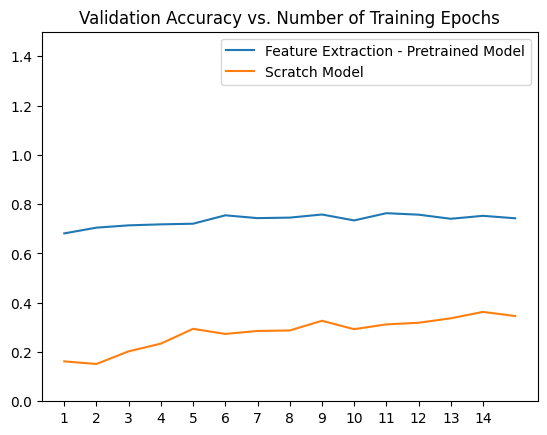

In [14]:
# plot the history curves
hist_0_numpy = [h.cpu().numpy().item() for h in hist_0]
hist_2_numpy = [h.cpu().numpy().item() for h in hist_2]
plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.plot(range(1, len(hist_0_numpy) + 1), hist_0_numpy, label="Feature Extraction - Pretrained Model")
plt.plot(range(1, len(hist_2_numpy) + 1), hist_2_numpy, label="Scratch Model")
plt.ylim(0, 1.5)
plt.xticks(np.arange(1, len(hist_0_numpy), 1.0))
plt.legend()
plt.show()

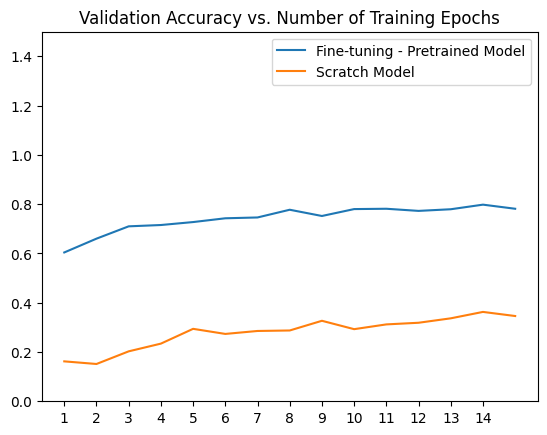

In [15]:
# plot the history curves
hist_1_numpy = [h.cpu().numpy().item() for h in hist_1]
hist_2_numpy = [h.cpu().numpy().item() for h in hist_2]
plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.plot(range(1, len(hist_1_numpy) + 1), hist_1_numpy, label="Fine-tuning - Pretrained Model")
plt.plot(range(1, len(hist_2_numpy) + 1), hist_2_numpy, label="Scratch Model")
plt.ylim(0, 1.5)
plt.xticks(np.arange(1, len(hist_0_numpy), 1.0))
plt.legend()
plt.show()